<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/RoBERTa_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/4650a1f9-a8a4-4b31-b01f-aee216098c6e


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):  # Fixed this line
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())


                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(lemmatized)


# Ensure all values in 'Question_body' are strings and handle NaNs and # Convert 'Question_body' to string (to avoid NaN issues)
dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)


# Split dataset

In [ ]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataset['Question_body_preprocessed'].tolist(),
    dataset['Label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [ ]:
print(f"Type of train_texts: {type(train_texts)}")
print(f"Type of test_texts: {type(test_texts)}")

# If they are lists, check the type of their elements
if isinstance(train_texts, (list, tuple)):
    print(f"Type of elements in train_texts: {type(train_texts[0])}")
if isinstance(test_texts, (list, tuple)):
    print(f"Type of elements in test_texts: {type(test_texts[0])}")

Type of train_texts: <class 'list'>
Type of test_texts: <class 'list'>
Type of elements in train_texts: <class 'str'>
Type of elements in test_texts: <class 'str'>


In [ ]:
train_texts = [str(text) for text in train_texts]
test_texts = [str(text) for text in test_texts]

# Load the RoBERTa Model and Tokenizer

In [ ]:
# Tokenize the data
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

## Create dataset class

In [ ]:
# Create dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
test_dataset = Dataset(test_encodings, test_labels)

## Load Model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define training arguments
https://chatgpt.com/share/f24dcc21-cb8b-4fa3-89d3-a296eed0d3dd

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',                # Directory to save the model and other outputs
    num_train_epochs=3,                    # 3 epochs is often sufficient for BERT/RoBERTa
    per_device_train_batch_size=32,        # Batch size per device; adjust based on GPU memory. Use a large bacth size that fits in memory
    per_device_eval_batch_size=32,         # Evaluation batch size; should be consistent with training
    warmup_steps=500,                      # Number of steps to perform linear learning rate warmup
    weight_decay=0.01,                     # Regularization term to prevent overfitting
    learning_rate=3e-5,                    # Lower LR to 3e-5 or 2e-5 since 1e-3 is too high for fine-tuning transformers
    logging_dir='./logs',                  # Directory to save logs for TensorBoard
    logging_steps=10,                      # Log every 10 steps
    evaluation_strategy="epoch",            # Evaluate the model after each epoch
    save_strategy="epoch",                 # Save model at the end of each epoch
    gradient_accumulation_steps=2,          # Simulate a larger batch size if needed
    lr_scheduler_type="linear",            # Linear decay of learning rate
    load_best_model_at_end=True,           # Load the best model based on evaluation
    report_to="none",
    seed=42                                # Ensure reproducibility
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Define evaluation metric

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create Trainer instance

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,

)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.195900,0.164900,0.942082,0.941296,0.951956,0.930872
2,0.134000,0.173737,0.948108,0.946087,0.981949,0.912752


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.195900,0.164900,0.942082,0.941296,0.951956,0.930872
2,0.134000,0.173737,0.948108,0.946087,0.981949,0.912752
3,0.086900,0.127666,0.959826,0.959569,0.963464,0.955705


TrainOutput(global_step=561, training_loss=0.2477894402515814, metrics={'train_runtime': 3671.0796, 'train_samples_per_second': 9.761, 'train_steps_per_second': 0.153, 'total_flos': 9428584668825600.0, 'train_loss': 0.2477894402515814, 'epoch': 3.0})

# Evaluate the model

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.12766627967357635, 'eval_accuracy': 0.9598259122865752, 'eval_f1': 0.9595687331536388, 'eval_precision': 0.9634641407307172, 'eval_recall': 0.9557046979865772, 'eval_runtime': 84.3533, 'eval_samples_per_second': 35.411, 'eval_steps_per_second': 1.114, 'epoch': 3.0}


## Make predictions on Evaluation dataset

In [ ]:
# Make predictions
predictions = trainer.predict(test_dataset)
y_true = test_labels
y_pred = predictions.predictions.argmax(-1)

## Printing Rediction Results: Metrics

In [ ]:
# Calculate overall metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

# Print overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {accuracy}')


Overall Precision: 0.9634641407307172
Overall Recall: 0.9557046979865772
Overall F1-score: 0.9595687331536388
Overall Accuracy: 0.9598259122865752
Class 0 - Precision: 0.9562624254473161, Recall: 0.9639278557114228, F1-score: 0.9600798403193613
Class 1 - Precision: 0.9634641407307172, Recall: 0.9557046979865772, F1-score: 0.9595687331536388


# The following code computes not only the precision, recall, F1-score, and support for each class but also attempts to calculate accuracy for each class separately using the confusion matrix.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)

#print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Accuracy: {accuracy_class_0}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]},  Accuracy: {accuracy_class_1}')


Class 0 - Precision: 0.9562624254473161, Recall: 0.9639278557114228, F1-score: 0.9600798403193613, Accuracy: 0.9598259122865752
Class 1 - Precision: 0.9634641407307172, Recall: 0.9557046979865772, F1-score: 0.9595687331536388,  Accuracy: 0.9598259122865752


In [ ]:
saved_model_path = './saved_model'
model.save_pretrained(saved_model_path)
tokenizer.save_pretrained(saved_model_path)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json')

## Confusion Matrix
A confusion matrix provides a visual representation of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

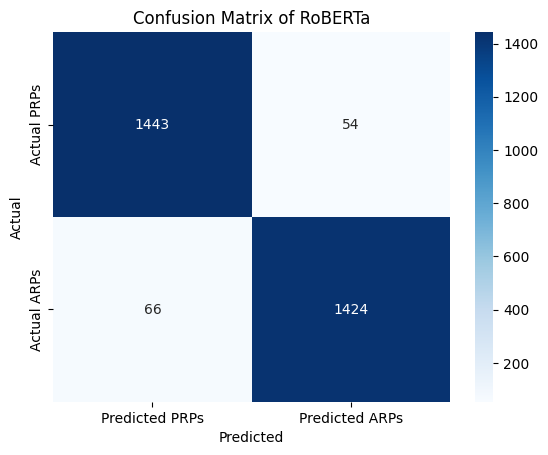

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted PRPs', 'Predicted ARPs'], yticklabels=['Actual PRPs', 'Actual ARPs'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of RoBERTa')
plt.show()